## User guide of `pyenvlp`

### Import package

In [21]:
import pyenvlp

This package implements the fitting of response envelope and predictor envelope.  Its core optimization has a Python implementation and a cpp implementation.  The cpp implementation is faster and can be run on large problems.  The Python implementation is more suitable to moderate sized problems.  The program uses faster cpp version if available, else uses the Python version.

In [103]:
# To check if the cpp implementation is used
pyenvlp.opt.USE_CPP_ENVOPT

True

### Prepare data

We will use the wine data as an illustration.  The wine class is taken as predictor, and wine characteristics are taken as response vector.  We fit a response envelope model.  The response and predictors should be in matrix form (np.array).  If a predictor is categorical, make sure to use one-hot encoding.  Remove one class to make sure that the predictor columns are linearly independent.  

In [22]:
import numpy as np
import pandas as pd
from sklearn import datasets

In [49]:
# Load data
wine = datasets.load_wine()
# Create response
Y = np.array(datasets.load_wine().data)
Y[:2,:]

array([[1.423e+01, 1.710e+00, 2.430e+00, 1.560e+01, 1.270e+02, 2.800e+00,
        3.060e+00, 2.800e-01, 2.290e+00, 5.640e+00, 1.040e+00, 3.920e+00,
        1.065e+03],
       [1.320e+01, 1.780e+00, 2.140e+00, 1.120e+01, 1.000e+02, 2.650e+00,
        2.760e+00, 2.600e-01, 1.280e+00, 4.380e+00, 1.050e+00, 3.400e+00,
        1.050e+03]])

In [71]:
# Create predictors
df = pd.DataFrame(wine.target, columns=["class"])
df_one_hot = pd.get_dummies(df, columns=["class"])
# make sure columns in X are independent
df_one_hot = df_one_hot.drop(columns=['class_0'])  
X = df_one_hot.to_numpy()
X[:2,:]

array([[0, 0],
       [0, 0]], dtype=uint8)

### Fit response envelope

In [64]:
# syntax of pyenvlp.fit_yenv
help(pyenvlp.fit_yenv)

Help on function fit_yenv in module pyenvlp.fit:

fit_yenv(X, Y, u, init=None, asy=True)
    Fits envelope model of Y, given envelope subspace dimension u.
    Returns the envelope modified beta, along with other measures
    involved in solving for projection matrix. Y matrix is usually
    multi-target, and X can be a single vector or multi-dimensional.
    
    Args:
        X : (n x p)
        Y : (n x r)
        u : scalar integer between [0, r]
    
        omegahat = gammahat.T @ M @ gammahat
        omega0hat = gamma0hat.T @ sigY @ gamma0hat
        sigma1 = gammahat @ omegahat @ gammahat.T
        sigmahat = sigma1 + (gamma0hat @ omega0hat @ gamma0hat.T)
        loglik = -n * r / 2 * (np.log(2 * np.pi) + 1) - n / 2 * objfun
        etahat = gammahat.T @ betaOLS  # reduction to dimension u
    
    Returns dict with keys:
        gamma       : projection matrix for material info Y|X
        gamma0      : projection matrix for immaterial info
        mu:         : intercept comp

In [65]:
# Fit response envelope
m = pyenvlp.fit_yenv(X, Y, 1)  # set u = 1 as an example

In [66]:
# Fitted parameters
m.keys()

dict_keys(['gammahat', 'gamma0hat', 'objfun', 'niter', 'opt_elapsed', 'u', 'r', 'p', 'U', 'M', 'betaols', 'beta', 'mu', 'sigma', 'eta', 'omega', 'omega0', 'loglik', 'covMatrix', 'asySE', 'ratio'])

In [67]:
m['beta']

array([[-9.89484278e-01, -8.06207967e-01],
       [ 4.06127195e-01,  3.30902661e-01],
       [-1.16227011e-01, -9.46989700e-02],
       [ 2.78581430e+00,  2.26981442e+00],
       [-1.06570426e+01, -8.68310177e+00],
       [-5.90282529e-01, -4.80947993e-01],
       [-9.34649175e-01, -7.61529645e-01],
       [ 7.34060632e-02,  5.98094930e-02],
       [-3.58178937e-01, -2.91835574e-01],
       [-1.38775187e+00, -1.13070681e+00],
       [-1.02202358e-01, -8.32720211e-02],
       [-4.20383431e-01, -3.42518298e-01],
       [-5.96229774e+02, -4.85793665e+02]])

* Note: When we have large number of rows, `pyenvlp.fit_yenv_gram` directly work with the gram matrices, which is a memory friendly option.

In [68]:
help(pyenvlp.fit_yenv_gram)

Help on function fit_yenv_gram in module pyenvlp.fit:

fit_yenv_gram(sigY, sigYX, sigX, u, init=None)
    Fit envelope model using grammian matrices cov(y, y), cov(x, y), cov(x, x).
    Called by top-level function fit_yenv that uses full matrices X, Y.



* Note: For predictor envelope model, the corresponding functions are `pyenvlp.fit_xenv` and `pyenvlp.fit_xenv_gram`.

### Selection of u

Selection of `u` can be performed with `envOpt`.  It fits envelope models with different `u` in parallel, therefore improves the efficiency.  

To use `envOpt`, we need the $M$ and $U$ matrices, where $M$ and $U$ are square matrices that appear in the objective function of a generic envelope optimization problem
$$
\arg\min_{\scriptstyle{\Gamma}}\log|\Gamma^TM\Gamma| + \log|\Gamma^T(M+U)^{-1}\Gamma|,
$$
where the optimization is performed on an $r\times u$ Grassmann manifold.  

* For response envelope, $M=\hat{\Sigma}_{Y\mid X}$, $U=\hat{\Sigma}_{Y}-M$.
* For predictor envelope, $M=\hat{\Sigma}_{X\mid Y}$, $U=\hat{\Sigma}_{X}-M$.

In [74]:
# Compute M and U
n, r = Y.shape
sigY = np.cov(Y, rowvar=False) 
sigX = np.cov(X, rowvar=False)  
invsigX = np.linalg.inv(sigX) # Use Cholesky decomposition
sigYX = np.cov(Y, X, rowvar=False)[:Y.shape[1], Y.shape[1]:]
sigRes = (sigY - sigYX @ invsigX @ sigYX.T) * (n - 1) / n

M = sigRes
U = sigY - M

In [75]:
# Initialize 
eopt = pyenvlp.EnvOpt(M, U)

We will use `pyenvlp.EnvOpt.sweep` for selection of u.  This function find the u that minimizes BIC.  The input of this function includes
* `u_list`: A list of possible u values
* `n`: Sample size
* `objval_offset`: A constant used to get the exact BIC value.  It is 0 for response envelope model, and for predictor envelope model it is $-n/2 * \log|\hat{\Sigma}_{Y}|$. Default value: 0.
* `p`: When fitting response envelope models, take p to be number of predictors.  When fitting predictor envelope models, take p to be number of responses.  Default value: 1.

In [119]:
help(pyenvlp.EnvOpt.sweep)

Help on instancemethod in module pyenvlp._pyenvlp:

sweep(...)
    sweep(self: pyenvlp._pyenvlp.EnvOpt, u_list: list[int], n_samples: int, objval_offset: float = 0.0, p: int = 1) -> tuple



In [120]:
# Get the list of possible u
ulist = np.arange(0, r+1).tolist()
ulist

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

In [122]:
# dimension selection based on BIC criteria
# n is the sample size
# offset = 0 for response envelope model
# number of predictors is 2
objval, best_u = eopt.sweep(ulist, n, 0, 2)
best_u

9

In [123]:
objval

array([[8224.32580424],
       [8017.08391099],
       [7812.0142472 ],
       [7800.68565027],
       [7699.06812193],
       [7670.93997236],
       [7643.94234441],
       [7634.44878129],
       [7630.3897961 ],
       [7619.74043605],
       [7627.67383283],
       [7632.09671056],
       [7635.77665659],
       [7643.71064946]])

Once u is selected, we can use `pyenvlp.fit_yenv` to fit the model

In [88]:
m = pyenvlp.fit_yenv(X, Y, best_u)
m['beta']

array([[-1.47881978e+00, -6.01794913e-01],
       [-7.84027281e-02,  1.32834180e+00],
       [-2.03403618e-01, -2.52160047e-02],
       [ 3.22576801e+00,  4.34026565e+00],
       [-1.06647541e+01, -8.72973408e+00],
       [-5.72958162e-01, -1.16068996e+00],
       [-8.98421584e-01, -2.20782792e+00],
       [ 6.46921007e-02,  1.67374094e-01],
       [-2.83505263e-01, -7.80132203e-01],
       [-2.43370307e+00,  1.86547275e+00],
       [-4.73993206e-03, -3.82299357e-01],
       [-3.57809848e-01, -1.45441775e+00],
       [-5.96224827e+02, -4.85785723e+02]])

If only the estimate of $\Gamma$ and $\Gamma_0$ are interested, we can also use `EnvOpt` to obtain the estimates as well as a few key statistics.

In [92]:
# Solve the envelope optimization with given u
eopt.solve(best_u) 

In [98]:
# Get the estimates of Gamma and Gamma_0
Gammahat, Gamma0hat = eopt.get_gammas()

In [124]:
# Get the value of the objective function at the solution
eopt.get_objvalue()

-3.312184968515104

In [102]:
# Get statistics related to the optimization 
eopt.get_stats()

{'elapsed': 0.005559284, 'iter': 8, 'lbfgs_iter': 5921}

## Comparison of `pyenvlp` and `Renvlp`

### Fitting with known u
* data simulated from a response envelope model $Y=\beta X + \epsilon$
* $r=100$, $p=100$, $n=500$
* $50$ replications for each $u$
* $X\sim N(0, 400I_{p})$
* $\beta=\Gamma\eta$, where $(\Gamma, \Gamma_0)$ formed an orthogonal matrix and elements in $\eta$ followed independent uniform $(0,10)$ distribution.
* $\epsilon\sim N(0, \Sigma)$, where $\Sigma=\Gamma\Omega\Gamma^T+\Gamma_0\Omega_0\Gamma_0^T$, $\Omega=AA^T$ and $\Omega_0=BB^T$.  Elements in $A$ followed $N(0, 1)$ and elements in $B$ followed $N(0, 25)$ distribution.
* Average computing time (in seconds) and average $\|\hat{\beta}-\beta\|_2$ is displayed below.

|  |  Time (sec) || $\hat{\beta}-\beta$ ||
|----------|----------|----------|----------|----------|
| $u$ | pyenvlp | Renvlp | pyenvlp | Renvlp |
|----------|----------|----------|----------|----------|
| 1    | 0.49     | 2.03     | 0.18     | 0.34     |
| 5    | 0.76     | 4.52     | 0.87     | 0.89     |
| 10    | 0.78     | 5.38     | 1.37     | 1.08     |
| 20    | 1.49     | 5.43     | 1.39     | 1.44     |
| 30    | 2.20     | 7.00     | 1.48     | 1.32     |
| 40    | 2.76     | 5.64     | 1.40     | 1.54     |
| 50    | 2.77     | 6.31     | 1.44     | 1.43     |
| 60    | 3.00     | 6.65     | 1.33    | 1.30     |
| 80    | 1.88     | 5.37     | 0.99     | 1.06     |
| 90    | 1.08     | 3.78     | 0.84     | 0.78     |
* The `pyenvlp` version is 2-5 times faster than `Renvlp`, while achieving similar accuracy.

<Axes: title={'center': 'runtime in sec as function of u dimension: lower is better'}, xlabel='u'>

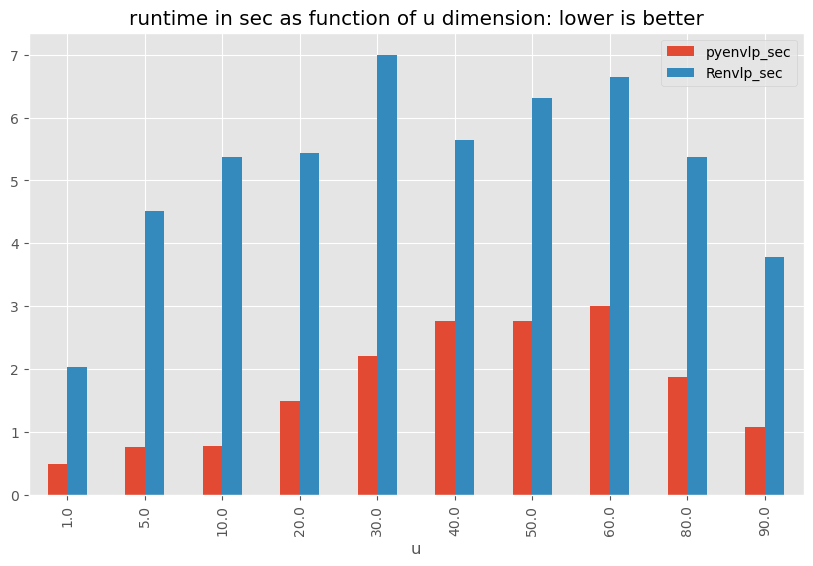

In [21]:
import pandas as pd
import matplotlib.pylab as plt
plt.style.use("ggplot")
txt = """
| 1    | 0.49     | 2.03     | 0.18     | 0.34     |
| 5    | 0.76     | 4.52     | 0.87     | 0.89     |
| 10    | 0.78     | 5.38     | 1.37     | 1.08     |
| 20    | 1.49     | 5.43     | 1.39     | 1.44     |
| 30    | 2.20     | 7.00     | 1.48     | 1.32     |
| 40    | 2.76     | 5.64     | 1.40     | 1.54     |
| 50    | 2.77     | 6.31     | 1.44     | 1.43     |
| 60    | 3.00     | 6.65     | 1.33    | 1.30     |
| 80    | 1.88     | 5.37     | 0.99     | 1.06     |
| 90    | 1.08     | 3.78     | 0.84     | 0.78     |
"""
lines = txt.split("\n")
data = []
for line in lines:
    toks = line.split("|")
    toks = [float(i) for i in [tok.strip() for tok in toks] if len(i)>0]
    if len(toks)==0:
        continue
    data.append( dict(zip(["u","pyenvlp_sec","Renvlp_sec","pyenvlp_norm","Renvlp_norm"], toks)) )
    # print(toks)
df = pd.DataFrame(data)
# display(df)
df.set_index("u")[["pyenvlp_sec", "Renvlp_sec"]].plot.bar(figsize=(10,6), title="runtime in sec as function of u dimension: lower is better")

### Selection of u

* Same settings as above, but fix u = 5, r varies from 20 to 200
* 5 replications for each u
* When r is large, it is common to choose a dimension that is larger than u.  If the estimated envelope contains the true envelope, then the angle between $\hat{\Gamma}$ and $\Gamma$ should be small.  For this purpose, the angle is also included in the table.

|  |  Time (sec) ||Angle ||
|----------|----------|----------|----------|----------|
| $r$ | pyenvlp | Renvlp | pyenvlp | Renvlp |
|----------|----------|----------|----------|----------|
| 20    | 0.02     | 0.46     | 0.43     | 0.52     |
| 50    | 0.81     | 8.73     | 1.20     | 0.86     |
| 100    | 7.27     | 99.26     | 1.93    | 1.87     |
| 200    |  238.21    | 1197.78     | 2.11     | 2.28     |

* EnvOpt is much faster in selection of u compared to Renvlp. It may select a u which is slightly larger, but it normally contains the true envelope subspace.